In [1]:
clean_up = True # if True, remove all gams related files from working folder before starting
%run stdPackages.ipynb
os.chdir(main)
%run stdPlotting.ipynb
os.chdir(d['py'])
from gmsPython import nestingTree
from valueShares import nestedShares_noOutputs, nestedShares
from mCGE import CGE

The file _gams_py_gdb0.gdx is still active and was not deleted.
The file _gams_py_gdb3.gdx is still active and was not deleted.
The file _gams_py_gdb4.gdx is still active and was not deleted.
The file _gams_py_gdb5.gdx is still active and was not deleted.


# CGE model

*Load data:*

In [2]:
t0 = 2019 # set baseline year
name = 'vA' # specify name of the CGE version we are currently working on
db = GpyDB(os.path.join(d['data'], f'{name}_{t0}'), name = '_'.join([name, str(t0), 'solDB'])) # load and rename database 
dbIO = db.copy() # create copy without adjustments made along the way
ws = db.ws # run everything from the same ws

Initialize model:

In [3]:
M = CGE('_'.join([name, str(t0), 'CGE']), database = db)
# M.db['rDepr'] = M.steadyStateDepr() # use this to adjust depreciation rates to get steady state investments in baseline year

## 1. Adding modules:

### 1.1. Production

The production module is initialized with a nesting tree and value shares to identify the $\mu$-share parameters of the nesting structure.

Nesting structure:

In [4]:
wasteNest = adj.rc_pd(db('nestProduction'), pd.Index(['Waste'], name = 's')) # the adj.rc_pd(s, c) adjusts the symbol 's' by matching with the condition 'c'. It operates by matching the indices.
otherNest = db('nestProduction').difference(wasteNest) 

Initialize trees:

In [5]:
waste = nestingTree.Tree('W', tree = wasteNest.to_list(), f = 'CES') 
other = nestingTree.Tree('O', tree = otherNest.to_list(), f = 'CES')
nest = nestingTree.AggTree(name = 'P', trees = {t.name: t for t  in (waste, other)}, ws = ws)
nest(namespace = {str(n)+'_input':n for n in db('n')}) # the __call__ method establishes relevant symbols to create the gams model

In [6]:
v = nestedShares(nest, ws = ws)
db_vs = v(dbIO) # one-liner that returns solution database

Use share parameters and values to get initial values for intermediates:

In [7]:
db.aom(db_vs('mu').xs(t0), name = 'mu') 
db.aom(adj.rc_pd(db_vs('vD'), nest.get('int')).rename('qD'), name = 'qD', priority = 'first') # specify intermediate goods levels

Use static user cost as initial guess for price on durables (if no other has been provided):

In [8]:
db.aom(db('pD_dur'), name = 'pD', priority = 'first') # pD_dur includes an estimate of the long-run user-cost of capital

Next, we initialize the production module:

In [9]:
M.addProductionModule(nest, partial = True, mtype = 'NestedCES', initFromGms = 'initFirmValue', taxInstr = 'tauLump')

### 1.2. Investment module

Similar to production module, but without accumulation of durables:

In [10]:
nest = nestingTree.AggTree(name = 'I', trees = {'I': nestingTree.Tree('I', tree = db('nestInvestment').to_list(), f = 'CES')}, ws = ws)
nest(namespace = {str(n)+'_input':n for n in db('n')})

*Define share parameters:*

In [11]:
v = nestedShares(nest, ws = ws)
db_vs = v(dbIO) 

*Use share parameters and values to get initial values for intermediates:*

In [12]:
db.aom(db_vs('mu').xs(t0), name = 'mu') 
db.aom(adj.rc_pd(db_vs('vD'), nest.get('int')).rename('qD'), name = 'qD', priority = 'first') # specify intermediate goods levels

*Add module as production type to CGE:*

In [13]:
M.addInvestmentModule(nest, partial = True, mtype = 'NestedCES')

### 1.3. Consumer module

*Nesting tree:*

In [14]:
cesNest = nestingTree.Tree('HH', tree = db('nestHH').to_list(), f = 'CES')
nest = nestingTree.AggTree(name = 'HH', trees = {t.name: t for t in [cesNest]}, ws = ws)
nest(namespace = {str(n)+'_input': n for n in db('n')})

Value shares:

In [15]:
v = nestedShares_noOutputs(nest, ws = ws)
db_vs = v(dbIO) # one-liner that returns solution database

Add to main database:

In [16]:
db.aom(db_vs('mu').xs(t0), name = 'mu') 
db.aom(adj.rc_pd(db_vs('vD'), nest.get('int').union(nest.get('output'))).rename('qD'), name = 'qD', priority = 'first') # specify intermediate goods levels

Add as consumer module:

In [17]:
M.addConsumerModule(nest, L2C = db('L2C'), partial = True, mtype = 'StaticConsumer')

### 1.4. Government sector

Nesting tree:

In [18]:
cesNest = nestingTree.Tree('G', tree = db('nestG').to_list(), f = 'CES')
nest = nestingTree.AggTree(name = 'G', trees = {t.name: t for t in [cesNest]}, ws = ws)
nest(namespace = {str(n)+'_input': n for n in db('n')})

Value shares:

In [19]:
v = nestedShares_noOutputs(nest, ws = ws)
db_vs = v(dbIO)

Add to main database:

In [20]:
db.aom(db_vs('mu').xs(t0), name = 'mu') 
db.aom(adj.rc_pd(db_vs('vD'), nest.get('int').union(nest.get('output'))).rename('qD'), name = 'qD', priority = 'first') # specify intermediate goods levels

Add module:

In [21]:
M.addGovernmentModule(nest, L = db('L2C').droplevel('nn').unique())

### 1.5. Simple modules

**Inventory investments** are added. Here, we use a simple AR(1) process (default parameter = 1) as we mostly include this for completeness:

In [22]:
M.addInventoryModule('Itory')

The **trade module** is a simple Armington module that only requires information already established in the IO database. Specifically, the module draws on the subset ```dExport[s,n]``` to establish what sector, goods combinations are covered by the trade module. If we want to only use this module to cover a subset of this (maybe trade should be modelled in a different way than Armington), we simply pass a new subset to the init method:

In [23]:
M.addTradeModule('T', partial = True)
# M.addTradeModule('T', dExport = db('dExport')[0:2]) # syntax used if we want to specify that the module should only cover part of the full trade IO

We use a simple **emissions module** that applies end-of-pipe abatement to each sector. Regulation is simply modelled with exogenous tax rates on CO2 emissions, we do not have any carbon budgets included at the moment:

In [24]:
M.addEmissionsModule('M', partial = True)

Specify the distributional assumption for the EOP abatement:

In [25]:
M.compiler.locals['techType'] = "'normal'"

*Note: We add the equilibrium module later, after we solve for some initial values without these constraints.*

## 2. Small stuff

*Clean up database a bit (this is not necessary, but it removes some variables that are not ultimately used in the model):*

In [26]:
[db.series.__delitem__(k) for k in ('vD','vTax', 'vD_dur','vD_depr','vD_inv', 'vS', 'pD_dur') if k in db.symbols];

For variables that are defined over $t$, but where we do not yet have an initial value for all $t$, extrapolate from data:

*Note: This forces extrapolation of all variables defined over $t$ - if it is important that some variables are not extrapolated, they should be removed from this statement.*

In [27]:
[symbol.__setattr__('vals', extrapolateUpper(symbol.vals, db('tE')[0])) for symbol in [db[k] for k in db.varDom('t')['t']]];

Merge internally, i.e. write a gdx file from the Python database:

In [28]:
db.mergeInternal()

## 3. Solve

*Note: when we initialized (some of) the modules, we added  the condition ```partial = True```. This statement allows us to run the modules separately. For instance, the following cell would solve the production module by itself and add the solution to the main database. This can be used as a way of getting good initial values for the model or to run partial equilibrium experiments.*

*Example for how to run a module separately and store the result in the main database:*

In [29]:
# m = M.m['P'] # select module to run 
# soldb = m.jSolve(10, state = 'C', ϕ = .1) # solve calibration model with 10 steps and nonlinear grid (ϕ<1 means that adjustments to jTerms start large and then decrease)
# [m.db.aom(soldb[k], name = k) for k in m.groups[f'{m.name}_endo_C'].out]; # for all endogenous variables, add the solution to the main database again 
# m.db.mergeInternal() # update the gdx with the new solution

Calibrate the model without equilibrium constraints yet (the jSolve method automatically uses all the modules that we have added so far):

In [30]:
soldb = M.jSolve(10, state = 'C', ϕ = .5) # solve calibration model with 10 steps and nonlinear grid (ϕ<1 means that adjustments to jTerms start large and then decrease)

This illustrates how far off equilibrium the model is in a given year:

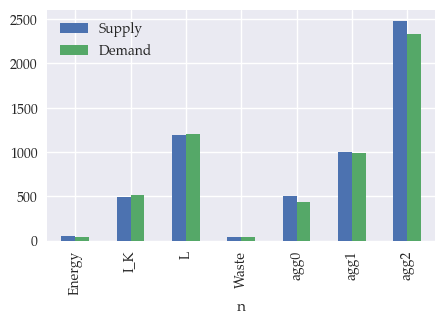

In [31]:
t = 2030
supply = adj.rc_pd(soldb('qS'), soldb('d_qS')).groupby(['t','n']).sum()
demand = adj.rc_pd(soldb('qD'), soldb('d_qD')).groupby(['t','n']).sum()
pd.DataFrame({'Supply': supply.xs(t), 'Demand': demand.xs(t)}).plot.bar(figsize=(5,3));

Write solution to the main database again:

In [32]:
[M.db.__setitem__(k, soldb[k]) for k in M.db.getTypes(['var']) if k in soldb.symbols]; # use solution database
M.db.mergeInternal()

Add equilibrium module and calibrate:

In [33]:
M.addEquilibriumModule('Equi')
fullSol = M.solve(state = 'C')

C:\Users\sxj477\Anaconda3\envs\GAMS46\Lib\site-packages\pyDatabases\gpyDB\database.py:525: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return ss.combine_first(s)


Add full solution to baseline model database:

In [34]:
[M.db.__setitem__(k, fullSol[k]) for k in M.db.getTypes(['var']) if k in fullSol.symbols]; # use solution database
M.db.mergeInternal()

## 4. Save/export

In [35]:
M.db.data_folder = d['data']

We can save/export the model in a few different ways:
1. Save model instance: The model class ```Model``` (parent class of the CGE class) is pickleable, meaning that we can save/load the class with Python's ```pickle``` class.
2. Store solution: It takes no time to re-initialize the ```Model``` class, so we can also simply store the solution database and - when needed - initialize the model class again.
3. Store GAMS code and solution: This option allows us to remove the model from the python class ```Model``` and instead treat it as a conventional GAMS program.

*Store model instance or database with pickle:*

In [36]:
M.export(repo = M.data_folder, name = M.name) # store the entire class - these are the default options by the way 
M.db.export(repo = M.db.data_folder, name = M.db.name) # store the solution database

*Export gams code and accompanying gdx file:*

In [37]:
baselineText = M.write(state = 'B') # store text so we can export it for later
text_gamY    = M.write_gamY(state = 'B') # store gamY text

In [38]:
with open(os.path.join(d['gams'], f'{M.name}.gms'), "w") as file:
    file.write(baselineText)
with open(os.path.join(d['gams'], f'{M.name}.gmy'), "w") as file:
    file.write(text_gamY)
M.db.database.export(os.path.join(M.db.data_folder, M.db.name))